In [1]:
import os
import pandas as pd
import numpy as np
import scanpy as sc
import re
from gimmemotifs.motif import Motif,read_motifs
from scipy.stats import zscore

from pyInfinityFlow.InfinityFlow_Utilities import pearson_corr_df_to_df
from pyInfinityFlow.InfinityFlow_Utilities import marker_finder

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42

%matplotlib inline

os.chdir("/media/kyle_storage/kyle_ferchen/grimes_lab_main/analysis/"\
    "2023_06_12_tea_seq_atac_processing/")

INFO:matplotlib.font_manager:Failed to extract font properties from /usr/share/fonts/truetype/noto/NotoColorEmoji.ttf: In FT2Font: Can not load face (unknown file format; error code 0x2)


In [2]:
# Read in the CITE-seq / InfinityFlow intersecting markers
marker_anno = pd.read_csv("input/surface_protein_info/"\
    "map_rna_to_cite_adts_to_infinityflow_channels.csv")

ai_markers_intersect = marker_anno[\
    ["RNA", "OPTI_ADT", "Name"]].dropna()["RNA"].values

In [3]:
# Read in the list of surface protein genes
sm_anno = pd.read_csv("output/chrombpnet/modisco_merged_results/fold_0/"\
    "redo_extract_seqlets/WITH_ALL_GENES/"\
    "seqlet_to_gene_expression_correlation_surface_marker_genes.csv")

sm_anno

,gene,cluster
0,Alcam,1
1,Entpd1,2
2,Il15,2
3,Cd1d1,3
4,Mfge8,5
...,...,...
254,Ccr1,169
255,Fcer1a,169
256,Cdh1,169
257,Cd200r3,169


In [4]:
# path_to_cluster_conns = "output/GRN/all_genes_no_threshold/cluster_specific_tf_links/"
# list_clusters = [i.split("_")[0] for i in os.listdir(path_to_cluster_conns)]
# sel_conns = []
# for i, tmp_cluster in enumerate(list_clusters):
#     print(f"{i+1}/{len(list_clusters)} Done...", end="\r", flush=True)
#     tmp_conns = pd.read_feather(os.path.join(\
#         path_to_cluster_conns, 
#         f"{tmp_cluster}_conns.fea"))
#     tmp_conns = tmp_conns.loc[tmp_conns["Gene"].isin(sm_anno["gene"].values)]
#     tmp_conns["cluster"] = tmp_cluster
#     sel_conns.append(tmp_conns)

In [5]:
path_to_cluster_conns = "output/GRN/all_genes_no_threshold/cluster_specific_tf_links/"
list_clusters = [i.split("_")[0] for i in os.listdir(path_to_cluster_conns)]
sel_conns = []
for i, tmp_cluster in enumerate(list_clusters):
    print(f"{i+1}/{len(list_clusters)} Done...", end="\r", flush=True)
    tmp_conns = pd.read_feather(os.path.join(\
        path_to_cluster_conns, 
        f"{tmp_cluster}_conns.fea"))
    tmp_conns = tmp_conns.loc[tmp_conns["Gene"].isin(ai_markers_intersect)]
    tmp_conns["cluster"] = tmp_cluster
    sel_conns.append(tmp_conns)

In [6]:
merged_conns = pd.concat(sel_conns)

In [7]:
tfa_to_genes = pd.pivot_table(\
    merged_conns, 
    index="TF_con", 
    columns="Gene", 
    values="con_score", 
    aggfunc=np.sum).fillna(0)
tfa_to_genes = np.log2(tfa_to_genes+1)

In [45]:
tfa_to_genes_z = zscore(tfa_to_genes, axis=1)

In [9]:
# Read in the CITE-seq RNA counts
path_cite_data = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/data/"\
    "2021_11_mouse_optimized_cite_seq/processed_files/"

adata_cite = sc.read(os.path.join(\
    path_cite_data, 
    "cite_seq_adata_rna_combined.h5ad"))
print("Computing CPTT normalized scRNA-seq from CITE-seq...")
adata_cite.X = np.log2((10000 * (adata_cite.X.T / \
    adata_cite.X.sum(axis=1).T).T) + 1)
cite_cell_anno = pd.read_csv(os.path.join(\
    path_cite_data, 
    "cite_seq_cell_annotations.csv"))
cite_cell_anno.index = cite_cell_anno["Cell_Barcode"].values

# Make pseudobulk RNA counts from cite clusters
print("Computing RNA centroids...")
shared_cells_cite = np.intersect1d(cite_cell_anno.index.values, 
    adata_cite.obs.index.values)
cite_cell_anno = cite_cell_anno.loc[shared_cells_cite]
cite_rna = {}
for tmp_cluster in cite_cell_anno["sctri_cite"].unique():
    print("\t{}...".format(tmp_cluster))
    tmp_barcodes = cite_cell_anno.loc[\
        cite_cell_anno["sctri_cite"] == tmp_cluster].index.values
    cite_rna[tmp_cluster] = pd.Series(np.asarray(\
            adata_cite[tmp_barcodes].X.mean(axis=0)).reshape(-1),
            index=adata_cite.var.index.values)

cite_rna = pd.DataFrame(cite_rna)
cite_rna = cite_rna.drop("Unknown", axis=1)
# map_r7_names = pd.read_csv(os.path.join(\
#     path_cite_data, 
#     "map_r7-v1_to_r7-v2_names.csv"))
# map_r7_names_v1_to_v2 = pd.Series(\
#     map_r7_names["R7_V2"].values,
#     index = map_r7_names["R7_V1"].values)

# cite_rna = cite_rna.rename(map_r7_names_v1_to_v2, axis=1)
# cite_rna.columns = [i.replace("-", "_") for i in cite_rna.columns.values]

Computing CPTT normalized scRNA-seq from CITE-seq...
Computing RNA centroids...
	ERP4--Ex...
	MultiLin-2_ML-c9--RNA...
	ERP2_Kit-c14--RNA...
	ERP2--Ex...
	Ebf1+_proB_CD127-c2--RNA...
	proNeu-1_1-4--ADT...
	Unknown...
	preNeu-2_1-8--ADT...
	cMoP_ML-c15--RNA...
	immNeu_Kit-c3--RNA...
	MP--Ex...
	proNeu-2_Kit-c4--RNA...
	Ebf1+_proB--Ex...
	ML_ERP1_ML-c4--RNA...
	MDP--Ex...
	preNeu-3_Kit-c2--RNA...
	ERP4_Kit-c13--RNA...
	preNeu-3_2-3--ADT...
	immNeu_2-5--ADT...
	preNeu-1_Kit-c5--RNA...
	immNeu_Kit-c1--RNA...
	cMoP--Ex...
	neoHPC_Myc--Ex...
	Bcl11b+_preETP--Ex...
	ML_Multi-Lin-2_HSC-c7--RNA...
	Ebf1+_proB_CD127-c8--RNA...
	IG2-proNeu1_ML-c14--RNA...
	ML_Mast--Ex...
	ML_cell_cycle_ML-c5--RNA...
	HSC-HPC-Cenpf_HSC-c12--RNA...
	MultiLin-2_ERP_ML-c10--RNA...
	ML_MDP_ML-c13--RNA...
	proNeu-1--Ex...
	SiglecH-Ly6C-pre-DC--Ex...
	HSC-HPC-Mki67--Ex...
	Pro-B_CD127-c3--RNA...
	precursor_B_cell_5-2--ADT...
	CLP1_CD127-c5--RNA...
	ML_MultiLin-1_ML-c8--RNA...
	ETP-A-0-Ccl4--Ex...
	ETP-CC-4-Ung--Ex...
	e

In [10]:
# Read in cluster annotations to map cluster order
path_cite_data = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/data/"\
    "2021_11_mouse_optimized_cite_seq/"
cluster_anno = pd.read_csv(os.path.join(path_cite_data, "processed_files/"\
    "cluster_anno_r6_r7_lvl4_and_order.csv"))
map_lvl4_to_order = pd.Series(\
    cluster_anno["Order"].values,
    index=cluster_anno["lvl4"].values).dropna().astype(int)
map_lvl4_to_color = pd.Series(\
    cluster_anno["Color"].values,
    index = cluster_anno["lvl4"].values)
map_r7_to_lvl4 = pd.Series(\
    cluster_anno["lvl4"].values,
    index=cluster_anno["R7"].values)
map_lvl4_to_order

qHSC           1
aHSC           2
HSC-Ly         3
MPP5-IER       4
MPP5 Ly-I      5
              ..
ILCP-b        83
ILC2          84
ILC1_3+NKP    85
pre-aceNKP    86
aceNKP        87
Length: 87, dtype: int64

In [11]:
path_fig1_heatmap_stuff = "/media/kyle_storage/kyle_ferchen/grimes_lab_main/"\
    "analysis/2023_06_14_nominate_regions_for_mpra_assay/output/plots_for_pub/"

rna_data_to_plot = pd.read_csv(os.path.join(\
        path_fig1_heatmap_stuff, 
        "rna_markers_heatmap.csv"), 
    index_col=0)
cell_assignments = pd.read_csv(os.path.join(\
        path_fig1_heatmap_stuff, 
        "cell_assigments_annotation.csv"), 
    index_col=0)
cell_assignments_reorder = cell_assignments.loc[rna_data_to_plot.columns.values]

cell_assignments_reorder["cluster"] = cell_assignments_reorder[\
    "original"].replace(map_r7_to_lvl4.to_dict()).values
cell_assignments_reorder["cluster_order"] = cell_assignments_reorder[\
    "cluster"].replace(map_lvl4_to_order.to_dict()).values
cell_assignments_reorder = cell_assignments_reorder.sort_values(\
    by=["cluster_order", "top_corr"], ascending=[True, False])
cells_to_plot = cell_assignments_reorder.loc[\
    cell_assignments_reorder["cluster"].isin(list_clusters)].copy()
cells_to_plot = cells_to_plot.sort_values(by="cluster_order")
cells_to_plot["barcode"] = [i.split(".")[0] for i in cells_to_plot.index.values]
cells_to_plot["port"] = cells_to_plot["port"].replace({\
    "AS_CITE_Multilin1": "AS_CITE_ML1",
    "AS_CITE_Multilin2": "AS_CITE_ML2"}).values
cells_to_plot.index = (cells_to_plot["port"] + "_" + \
    cells_to_plot["barcode"]).values
cells_to_plot

,top_cluster,top_corr,original,port,port_group,cluster,cluster_order,barcode
AS_CITE_HSC_TCGGATAGTGTCACAT-1,LT-HSC_Mllt3,0.929229,LT-HSC_Mllt3,AS_CITE_HSC,HSCP,qHSC,1,TCGGATAGTGTCACAT-1
AS_CITE_HSC_TCATGAGCAGCGGTCT-1,LT-HSC_Mllt3,0.904863,LT-HSC_Mllt3,AS_CITE_HSC,HSCP,qHSC,1,TCATGAGCAGCGGTCT-1
AS_CITE_HSC_TCTGTCGTCCGTGTGG-1,LT-HSC_Mllt3,0.904736,LT-HSC_Mllt3,AS_CITE_HSC,HSCP,qHSC,1,TCTGTCGTCCGTGTGG-1
AS_CITE_HSC_GTCTCACAGCGCTGAA-1,LT-HSC_Mllt3,0.904341,LT-HSC_Mllt3,AS_CITE_HSC,HSCP,qHSC,1,GTCTCACAGCGCTGAA-1
AS_CITE_HSC_CCTCAACAGGGCTGAT-1,LT-HSC_Mllt3,0.903068,LT-HSC_Mllt3,AS_CITE_HSC,HSCP,qHSC,1,CCTCAACAGGGCTGAT-1
...,...,...,...,...,...,...,...,...
AS_CITE_HSC_CAGCCAGAGCACCTGC-1,CLP1-Rrm2,0.890692,CLP1-Rrm2,AS_CITE_HSC,HSCP,CLP1-b,67,CAGCCAGAGCACCTGC-1
AS_CITE_ML1_GTCATTTGTCCTCCAT-1,CLP1-Rrm2,0.889931,CLP1-Rrm2,AS_CITE_ML1,MultiLin,CLP1-b,67,GTCATTTGTCCTCCAT-1
AS_CITE_ML1_GCTGCAGTCTCAACGA-1,CLP1-Rrm2,0.889729,CLP1-Rrm2,AS_CITE_ML1,MultiLin,CLP1-b,67,GCTGCAGTCTCAACGA-1
AS_CITE_ML2_CCTCCTCCAAGTATAG-1,CLP1-Rrm2,0.893052,CLP1-Rrm2,AS_CITE_ML2,MultiLin,CLP1-b,67,CCTCCTCCAAGTATAG-1


In [13]:
# Define marker genes according to cluster order of lvl4
list_target_genes = tfa_to_genes.columns.values
tmp_data = pd.DataFrame(\
    adata_cite[\
        cells_to_plot.index.values, 
        list_target_genes].X.toarray(),
    index=cells_to_plot.index.values,
    columns=list_target_genes)
r_df, p_df = marker_finder(tmp_data, cells_to_plot["cluster"].values)

marker_df = pd.DataFrame({\
    "top_cluster": r_df.idxmax(axis=1),
    "r": r_df.max(axis=1)},
    index=tmp_data.columns.values)
marker_df["cluster_order"] = marker_df["top_cluster"].replace(\
    map_lvl4_to_order.to_dict())
marker_df = marker_df.sort_values(by=["cluster_order", "r"], 
    ascending=[True, False])
marker_df = marker_df.dropna()

In [25]:
r_df, p_df = marker_finder(\
    tfa_to_genes.loc[:,marker_df.index.values].T, 
    marker_df["top_cluster"].values)

marker_df_tf = pd.DataFrame({\
    "top_cluster": r_df.idxmax(axis=1),
    "r": r_df.max(axis=1)},
    index=tfa_to_genes.index.values)
marker_df_tf["cluster_order"] = marker_df_tf["top_cluster"].replace(\
    map_lvl4_to_order.to_dict())
marker_df_tf = marker_df_tf.sort_values(by=["cluster_order", "r"], 
    ascending=[True, False])
marker_df_tf = marker_df_tf.dropna()

In [22]:
marker_df_tf = pd.DataFrame({\
    "top_cluster": r_df.idxmax(axis=1),
    "r": r_df.max(axis=1)},
    index=tmp_data.columns.values)

In [39]:
unique_groups = marker_df_tf["top_cluster"].unique()
vaxis_cluster_bar = pd.DataFrame(\
    [list(unique_groups).index(i) for i in marker_df_tf["top_cluster"].values],
    index=marker_df_tf.index.values,
    columns=["cluster"])
vaxis_color_series = map_lvl4_to_color.loc[unique_groups].copy()

vaxis_cluster_bar



,cluster
Zbtb17,0
Klf11,0
Klf4,0
Sp4,0
Mbtps2,0
...,...
Creb3l1,19
Nfyc,19
Prrxl1,19
Tfec,19


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 62 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'v', 'x', 'y', 'z', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 

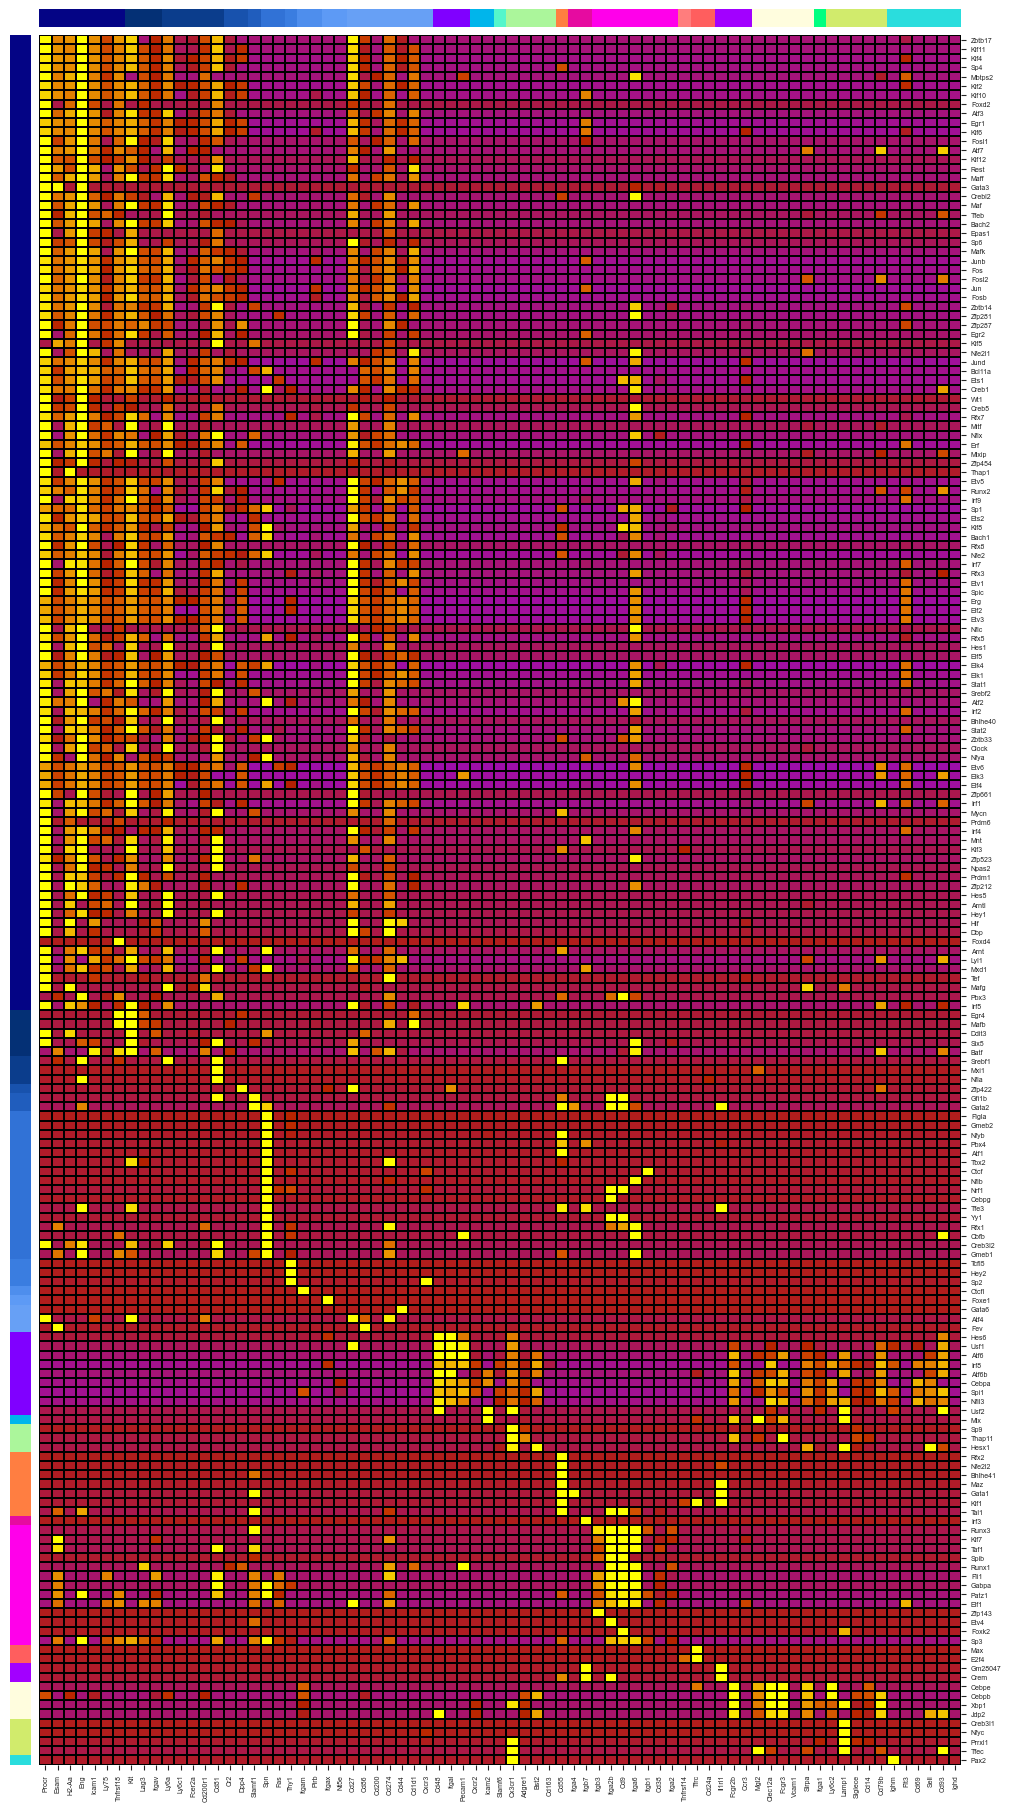

In [53]:
### Plotting heatmap of tf-activity to the different surface molecules

# Set up cluster bar for horizontal axis
unique_groups = marker_df["top_cluster"].unique()
haxis_cluster_bar = pd.DataFrame(\
    [list(unique_groups).index(i) for i in marker_df["top_cluster"].values],
    index=marker_df.index.values,
    columns=["cluster"])
haxis_color_series = map_lvl4_to_color.loc[unique_groups].copy()

# Set up cluster bar for vertical axis
unique_groups = marker_df_tf["top_cluster"].unique()
vaxis_cluster_bar = pd.DataFrame(\
    [list(unique_groups).index(i) for i in marker_df_tf["top_cluster"].values],
    index=marker_df_tf.index.values,
    columns=["cluster"])
vaxis_color_series = map_lvl4_to_color.loc[unique_groups].copy()


# Construct figure
fig = plt.figure(constrained_layout=True, figsize=(10,18))
ax = fig.add_gridspec(100, 180)
ax1 = fig.add_subplot(ax[1:, :4])
ax2 = fig.add_subplot(ax[0, 4:])
ax3 = fig.add_subplot(ax[1:, 4:])

# Vertical axis color bar
heat1 = sns.heatmap(vaxis_cluster_bar.astype(np.float32),
                        cmap=matplotlib.colors.ListedColormap(\
                            vaxis_color_series.values),
                        yticklabels=False,
                        xticklabels=False,
                        cbar=False,
                        ax=ax1)

# Horizontal axis colorbar
heat2 = sns.heatmap(haxis_cluster_bar.astype(np.float32).T,
                        cmap=matplotlib.colors.ListedColormap(\
                            haxis_color_series.values),
                        yticklabels=False,
                        xticklabels=False,
                        cbar=False,
                        ax=ax2)


tfa_to_genes_z.index.name = None
tfa_to_genes_z.columns.name = None
heat3 = sns.heatmap(\
    tfa_to_genes_z.loc[\
        marker_df_tf.index.values,
        marker_df.index.values].fillna(0), 
    vmin=-3, 
    vmax=3, 
    cmap="gnuplot",
    xticklabels=True,
    yticklabels=True,
    cbar=False,
    rasterized=True,
    linewidths=0.005, 
    linecolor='black',
    ax=ax3)

ax3.tick_params(bottom=True, top=False, left=False, right=True,
    labelbottom=True, labeltop=False, labelleft=False, labelright=True,
    labelsize=5)
ax3.set_yticklabels(ax3.get_yticklabels(), rotation='horizontal')

plt.savefig("output/GRN/all_genes/"\
    "tf_activities_heatmap_zscore_cite_inflow_surface_marker_intersect_order_by_lvl4_mf.pdf")

tfa_to_genes_z.to_csv("output/GRN/all_genes/"\
    "tf_activities_heatmap_zscore_cite_inflow_surface_marker_intersect_order_by_lvl4_mf.csv",
    header=True, index=True)

In [30]:
print(tfa_to_genes.max(axis=1).sort_values().to_string())

TF_con
Mlxipl      0.000031
Ctcfl       0.000053
Pax2        0.000075
Prrxl1      0.001752
Gata6       0.003626
Tcfl5       0.010767
Hey2        0.010862
Foxe1       0.015954
Figla       0.026692
Sp9         0.038341
Hesx1       0.038845
Fev         0.051905
Nfib        0.067950
Foxd4       0.079498
Gm28047     0.098493
Epas1       0.113571
Creb3l1     0.166680
Rfx2        0.208086
Tbx2        0.234237
Max         0.340671
Irf3        0.458433
Zfp454      0.530923
Bhlhe41     0.538084
Sp2         0.597864
Thap11      0.743700
Prdm6       1.059602
Wt1         1.171029
Spib        1.346355
Etv4        1.477050
Nfyc        1.570375
Hey1        1.720667
Tef         1.830502
Gata3       1.909451
Six5        1.921968
Dbp         1.943574
Cebpg       2.114946
Tfec        2.164774
Npas2       2.227899
Irf5        2.422973
Ddit3       2.465782
Egr4        2.508201
Creb5       2.517985
Prdm1       2.729358
Mlx         3.363437
Hes5        3.454459
Zfp143      3.492528
Mafb        3.676272
Elf5  

In [58]:
tfa_to_genes_z["Cd27"]

TF_con
Arnt      0.054583
Arntl    -0.264413
Atf1     -0.793434
Atf2      0.483655
Atf3      0.149271
            ...   
Zfp287    1.270276
Zfp422    1.827422
Zfp454   -0.784792
Zfp523    0.356678
Zfp661   -0.109492
Name: Cd27, Length: 189, dtype: float64

In [68]:
list_clusters

['aHSC',
 'BMCP',
 'CLP1-b',
 'ErP-1',
 'ErP-2',
 'ErP-HSC',
 'HSC-Ly',
 'IG2-MP',
 'IG2-proNeu1',
 'MDP-1',
 'MDP-2',
 'MEP',
 'MkP-HSC',
 'MkP-Kit',
 'ML-1b',
 'ML-2',
 'ML-3',
 'ML-CC',
 'ML-MDP',
 'MPP1-G1',
 'MPP1-MKP',
 'MPP2-G2',
 'MPP2-M',
 'MPP2-S',
 'MPP3-IER',
 'MPP3-S',
 'MPP4-TCA',
 'MPP5 Ly-I',
 'MPP5-IER',
 'MP',
 'proNeu-1a',
 'qHSC']

In [60]:
tfa_to_genes_z["Clec12a"].sort_values(ascending=False).head(20)

TF_con
Cebpb    5.753260
Cebpa    5.498772
Cebpe    5.486463
Spi1     5.220185
Irf8     4.981449
Nfil3    3.840599
Xbp1     3.317218
Jdp2     2.870987
Atf6b    0.789924
Atf6     0.562740
Usf2     0.191421
Mlx      0.049385
Usf1     0.026027
Tfec     0.023658
Nfic    -0.220640
Nfix    -0.220640
Nfya    -0.220640
Nfyb    -0.220640
Nfib    -0.220640
Nfia    -0.220640
Name: Clec12a, dtype: float64

In [61]:
tfa_to_genes_z["Vcam1"].sort_values(ascending=False).head(20)

TF_con
Cebpb     13.711309
Arnt      -0.072932
Nfe2      -0.072932
Nfe2l2    -0.072932
Nfia      -0.072932
Nfib      -0.072932
Nfic      -0.072932
Nfil3     -0.072932
Nfix      -0.072932
Nfya      -0.072932
Nfyb      -0.072932
Nfyc      -0.072932
Npas2     -0.072932
Nrf1      -0.072932
Patz1     -0.072932
Pax2      -0.072932
Pbx3      -0.072932
Pbx4      -0.072932
Prdm1     -0.072932
Prdm6     -0.072932
Name: Vcam1, dtype: float64

In [62]:
tfa_to_genes_z["Cx3cr1"].sort_values(ascending=False).head(20)

TF_con
Cebpa     6.437462
Spi1      6.280968
Irf8      5.765785
Xbp1      4.926306
Nfil3     4.027208
Usf2      2.759810
Atf6b     2.464209
Usf1      2.120629
Atf6      2.034438
Tfec      1.548390
Hes6      0.813602
Thap11    0.385023
Sp9      -0.192422
Hesx1    -0.205852
Prrxl1   -0.222659
Pax2     -0.223780
Nfyc     -0.223810
Nfic     -0.223810
Nfe2l2   -0.223810
Nfia     -0.223810
Name: Cx3cr1, dtype: float64

In [63]:
# list_sm_of_interest = ["Ly6a", "Cd27", "Kit", "Cd55", "Epor", "Clec12a", "Ly6c2", "Vcam1", "Cx3cr1"]

# top_5_each = []
# for tmp_sm in list_sm_of_interest:
#     tmp_set = tfa_to_genes_z[tmp_sm].sort_values(ascending=False).head(5)
#     tmp_set = tmp_set[tmp_set > 1]
#     top_5_each += list(tmp_set.index.values)

# top_5_each = np.unique(top_5_each)

In [64]:
# r_df, p_df = marker_finder(tfa_to_genes_z.loc[top_5_each, list_sm_of_interest].T, list_sm_of_interest)
# marker_df = pd.DataFrame({\
#     "TF": r_df.index.values,
#     "r": r_df.max(axis=1),
#     "top_group": r_df.idxmax(axis=1)})
# marker_df["group_order"] = [list_sm_of_interest.index(i)+1 for i in marker_df["top_group"].values]
# marker_df = marker_df.sort_values(by=["group_order", "r"], ascending=[True, False])
# marker_df

In [65]:
# fig = plt.figure(constrained_layout=True, figsize=(7,3))


# heat1 = sns.heatmap(\
#     tfa_to_genes_z.loc[\
#             marker_df["TF"].values, 
#             list_sm_of_interest].T, 
#     vmin=-3, 
#     vmax=3, 
#     cmap='gnuplot',
#     xticklabels=True,
#     yticklabels=True,
#     cbar=False,
#     rasterized=False,
#     linewidths=0.05, 
#     linecolor='black')

# plt.savefig("output/GRN/all_genes/"\
#     "tf_activities_heatmap_zscore_selected_surface_proteins_to_top_factors.pdf")

In [66]:
tfa_to_genes_z.index.values[tfa_to_genes_z.max(axis=1) > 2]

array(['Arnt', 'Atf1', 'Atf2', 'Atf6', 'Atf6b', 'Atf7', 'Bach1', 'Batf',
       'Bcl11a', 'Cbfb', 'Cebpa', 'Cebpb', 'Cebpe', 'Creb1', 'Crem',
       'Ctcf', 'E2f4', 'Egr1', 'Elf1', 'Elf2', 'Elf4', 'Elk1', 'Elk3',
       'Elk4', 'Erf', 'Erg', 'Ets1', 'Etv3', 'Etv5', 'Etv6', 'Fli1',
       'Fos', 'Fosb', 'Fosl2', 'Gabpa', 'Gata1', 'Gata2', 'Gfi1b', 'Hes6',
       'Irf1', 'Irf2', 'Irf8', 'Jdp2', 'Jun', 'Junb', 'Jund', 'Klf1',
       'Klf10', 'Klf2', 'Klf3', 'Klf4', 'Klf6', 'Klf7', 'Lyl1', 'Mafg',
       'Maz', 'Mlx', 'Mnt', 'Mxd1', 'Mycn', 'Nfe2', 'Nfe2l2', 'Nfia',
       'Nfil3', 'Nfix', 'Nfya', 'Nfyb', 'Nrf1', 'Patz1', 'Rest', 'Rfx7',
       'Runx1', 'Runx2', 'Runx3', 'Sp1', 'Sp2', 'Sp3', 'Sp4', 'Spi1',
       'Srebf1', 'Taf1', 'Tal1', 'Tfe3', 'Usf1', 'Usf2', 'Xbp1', 'Yy1',
       'Zfp143', 'Zfp281', 'Zfp287', 'Zfp422'], dtype=object)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern pruned
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 63 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'P', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'eight', 'f', 'five', 'four', 'g', 'h', 'hyphen', 'i', 'k', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'p', 'period', 'r', 's', 'seven', 'six', 'space', 't', 'three', 'two', 'u', 'underscore', 'v', 'x', 'y', 'z', 'zero']
INFO:fontTools.subset:G

<Figure size 2000x600 with 0 Axes>

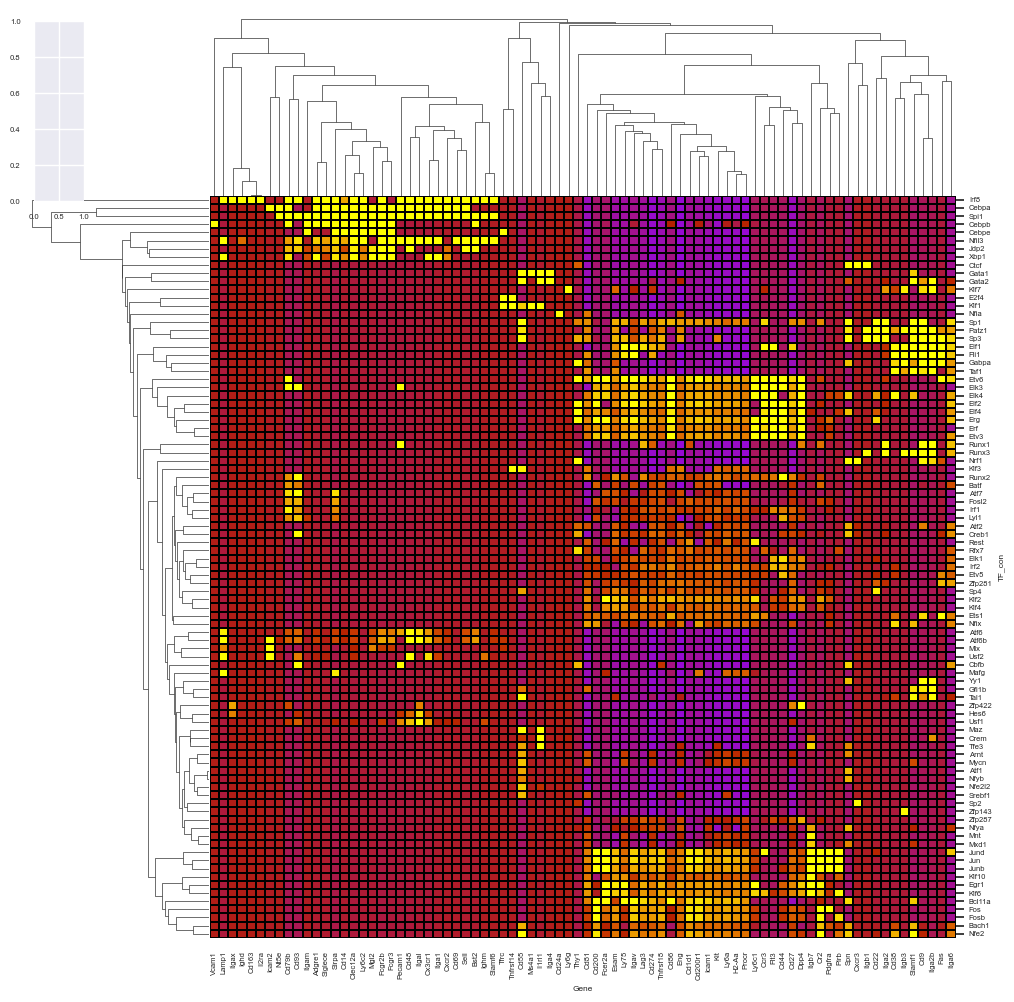

In [67]:
fig = plt.figure(constrained_layout=True, figsize=(20,6))

sns.set(font_scale=0.5)
heat1 = sns.clustermap(\
    tfa_to_genes_z.loc[tfa_to_genes_z.index.values[tfa_to_genes_z.max(axis=1) > 2]], 
    vmin=-3, 
    vmax=3, 
    cmap='gnuplot',
    xticklabels=True,
    yticklabels=True,
    cbar=False,
    rasterized=False,
    linewidths=0.005, 
    linecolor='black')

plt.savefig("output/GRN/all_genes/"\
    "tf_activities_heatmap_zscore_cite_inflow_marker_intersect.pdf")

In [39]:
tfa_to_genes_z

Gene,Adgre1,Bst2,Ccr3,Cd14,Cd163,Cd1d1,Cd200,Cd200r1,Cd22,Cd24a,...,Siglece,Sirpa,Slamf1,Slamf6,Spn,Tfrc,Thy1,Tnfrsf14,Tnfrsf18,Vcam1
TF_con,,,,,,,,,,,,,,,,,,,,,
Arnt,-0.186377,-0.180441,-0.311414,-0.18582,-0.073049,-0.596005,-0.429330,-0.507707,-0.175479,-0.072932,...,-0.174644,-0.275390,-0.380602,-0.122688,1.920816,-0.135111,-0.279701,-0.126151,-0.659057,-0.072932
Arntl,-0.186377,-0.180441,-0.311414,-0.18582,-0.073049,-0.596005,-0.429330,-0.589605,-0.189502,-0.072932,...,-0.174644,-0.202916,-0.380602,-0.122688,-0.427142,-0.135111,-0.279701,-0.126151,-0.733298,-0.072932
Atf1,-0.186377,-0.180441,-0.311414,-0.18582,-0.073049,-0.596005,-0.429330,-0.639426,-0.189502,-0.072932,...,-0.174644,-0.275390,-0.380602,-0.122688,2.408751,-0.135111,-0.279701,-0.126151,-0.733298,-0.072932
Atf2,-0.186377,-0.180441,-0.311414,-0.18582,-0.073049,-0.596005,-0.429330,-0.098860,-0.189502,-0.072932,...,-0.174644,-0.275390,-0.380602,-0.122688,2.281681,-0.135111,1.367061,-0.126151,1.067535,-0.072932
Atf3,-0.186377,-0.180441,-0.311414,-0.18582,-0.073049,0.886897,0.731434,0.516052,-0.189502,-0.072932,...,-0.174644,-0.275390,-0.380602,-0.122688,-0.427142,-0.135111,-0.279701,-0.126151,0.706735,-0.072932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zfp287,-0.186377,-0.180441,-0.124255,-0.18582,-0.073049,-0.596005,-0.429330,-0.486430,-0.189502,-0.072932,...,-0.174644,-0.275390,-0.380602,-0.122688,-0.427142,-0.135111,-0.279701,-0.126151,0.744812,-0.072932
Zfp422,-0.186377,-0.180441,-0.311414,-0.18582,-0.073049,-0.596005,-0.429330,-0.639426,-0.189502,-0.072932,...,-0.174644,-0.275390,-0.380602,-0.122688,-0.427142,-0.135111,-0.279701,-0.126151,-0.733298,-0.072932
Zfp454,-0.186377,-0.180441,-0.311414,-0.18582,-0.073049,-0.596005,-0.429330,-0.636841,-0.189308,-0.072932,...,-0.174644,-0.275390,-0.380602,-0.122688,-0.427142,-0.135111,-0.279701,-0.126151,-0.724848,-0.072932
